### Thermophysical Property Prediction

Empirical regression has limitations, especially when predictions are requested outside of the training region. Physics-based information can overcome this limitation by including fundamental engineering knowledge such as constraints during the training process. Constraints can be important physics-based information to improve machine learned predictions. Constraints are demonstrated on linear regression with sample data. The purpose of this [Thermophysical Property Case Study](https://apmonitor.com/pds/index.php/Main/ThermophysicalProperties) is to evaluate the performance of a neural network with and without constraints for thermophysical property predictions.

<img align=left width=400px src='https://apmonitor.com/pds/uploads/Main/thermophysical_properties.png'>

### Linear Regression with and without Constraints

Below is an example of linear regression with and without a lower bound constraint on a parameter. In this case, the constraint is on the slope ($a\ge0$).

Slope: -0.019506857458
Intercept: 0.48345795141
Slope: 0.0
Intercept: -0.50117452208


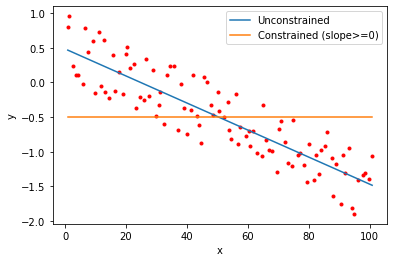

In [1]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

# define data
x = np.random.rand(100) + np.linspace(0,100,100)
y = np.random.rand(100) - 2*np.linspace(0,1,100)

# linear regression model with Gekko
m = GEKKO()

# unknown parameters
a,b = m.Array(m.FV,2)
a.STATUS = 1; b.STATUS = 1

# variables and parameters
yp = m.Var()
ym = m.Param(y)
xm = m.Param(x)

# equations and objective
m.Equation(yp == a*xm + b)
m.Minimize((yp-ym)**2)

# solve
m.options.IMODE = 2
m.solve(disp=False)
p1 = [a.value[0],b.value[0]]

print('Slope:', p1[0])
print('Intercept:', p1[1])

# add constraint to the slope (>=0)
a.LOWER = 0.0
m.solve(disp=False)
p2 = [a.value[0],b.value[0]]

print('Slope:', p2[0])
print('Intercept:', p2[1])

# plot results
plt.plot(x,y,'r.')
plt.plot(x,np.polyval(p1,x),label='Unconstrained')
plt.plot(x,np.polyval(p2,x),label='Constrained (slope>=0)')
plt.ylabel('y'); plt.xlabel('x'); plt.legend()
plt.show()

### Predict Thermophysical Properties

__Background__: Parachor values are a factor in the prediction of several thermophysical properties such as surface tension and thermal conductivity. The parachor value ($P$) is used to predict surface tension with the difference between the density of saturated liquid $\rho_L$ and saturated vapor $\rho_V$ at the temperature of interest.

$\sigma = \left(P\left(\rho_L-\rho_V\right)\right)^4$

Surface tension and thermal conductivity are two specific properties that need improved predictions. A more accurate predictor of the parachor value (P) is an important step to improve those thermophysical properties. Most deep learning methods use a limited set of activation functions (ReLU, sigmoid, tanh, and linear) and perform unconstrained regression to minimize a loss function. The purpose of this case study is to explore the addition of physics-based information in the fitting process. This may include the use of new types of activation functions or constraints on the adjustable weights. The data for this case study is from Gharagheizi, et. al. (2011) who explored deep learning (a multi-layered neural network) to improve parachor predictions for 277 compounds from 40 functional groups.

- Name: The common chemical name
- Formula: Chemical formula of the compound
- CASN: Chemical Abstracts Service Registry Number
- Family: Chemical family of the compound
- Parachor: Estimate of parachor value
- Grp1-Grp40: Number of functional groups in the compound

__Objective__: Develop a prediction of the parachar from the chemical compound data set. Report the correlation coefficient (R2) for predicting Parachor in the test set. Randomly select values that split the data into a train (80%) and test (20%) set. Use Linear Regression and Neural Network (Deep Learning) with constraints. The solutions for regression without constraints or feature engineering are provided in this notebook. For the constrained cases, enforce a positive parachor contribution for each group. Discuss the performance of each on the train and test sets. Submit source code and a summary memo (max 2 pages) of your results.

### Load Data

[Chemical Compound Data Set](http://apmonitor.com/pds/uploads/Main/thermo.txt)

```python
url = 'http://apmonitor.com/pds/uploads/Main/thermo.txt'
```

In [2]:
url = 'http://apmonitor.com/pds/uploads/Main/thermo.txt'

### Linear Regression without Constraints

ms_abs train
0.04432753191839437
ms_abs validate
0.04504518793460207


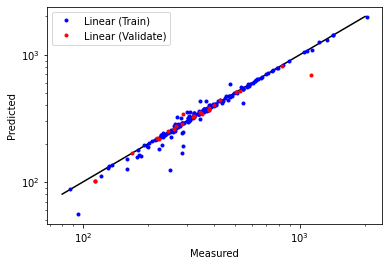

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(url)

# input
d = np.array(data)[:,-40:]
d = np.array(d,dtype=float)

d_train = d[0:205]
d_valid = d[205:]

# measured output
meas = np.array(data['Parachor'])
meas_train = meas[0:205]
meas_valid = meas[205:]

# linear regression
#  d * b = p
#  (d^T * d) * b = (d^T * meas)
#  A * b = rhs
A = np.dot(d_train.T,d_train)
rhs = np.dot(d_train.T,meas_train)
# solve for
#  b = inv(d^T*d)*d^T*p
b = np.linalg.solve(A,rhs)

# predicted output
pred_train = np.dot(d_train,b)
pred_valid = np.dot(d_valid,b)

print('ms_abs train')
print(np.sum(np.abs((meas_train-pred_train)/meas_train)/(len(meas_train))))
print('ms_abs validate')
print(np.sum(np.abs((meas_valid-pred_valid)/meas_valid)/(len(meas_valid))))

# parity plot
plt.loglog([80,2000],[80,2000],'k-')
plt.loglog(meas_train,pred_train,'b.',label='Linear (Train)')
plt.loglog(meas_valid,pred_valid,'r.',label='Linear (Validate)')
plt.legend()
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.show()

### Neural Network (Deep Learning) without Constraints in Keras / TensorFlow

1/1 [==============================] - 0s 15ms/step - loss: 0.0039
Mean Squared Error (Train):  0.00014330724661704153
Mean Squared Error (Valid):  0.003915001638233662
Mean sum abs diff - Training 0.03236110016655057
Mean sum abs diff - Validate 0.055530621872253244


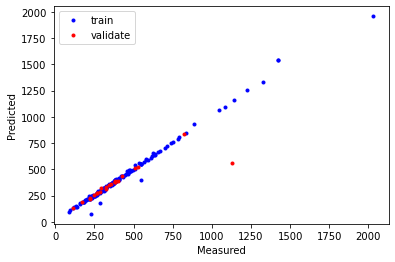

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import *
import matplotlib.pyplot as plt  

#################################################################
### Import Data #################################################
#################################################################

data = pd.read_csv(url)

# input
d = np.array(data)[:,-40:]
d = np.array(d,dtype=float)
x_train = d[0:205]
x_valid = d[205:]

# measured output
meas = np.array(data['Parachor'])
y_train = meas[0:205]
y_valid = meas[205:]

train = np.vstack((x_train.T,y_train)).T
valid = np.vstack((x_valid.T,y_valid)).T

#################################################################
### Scale data ##################################################
#################################################################

# scale values to 0 to 1 for the ANN to work well
s = MinMaxScaler(feature_range=(0,1))

# scale training and test data
sc_train = s.fit_transform(train)
xs_train = sc_train[:,0:-1]
ys_train = sc_train[:,-1]

sc_valid = s.transform(valid)
xs_valid = sc_valid[:,0:-1]
ys_valid = sc_valid[:,-1]

#################################################################
### Train model #################################################
#################################################################

# create neural network model
model = Sequential()
model.add(Dense(40, input_dim=40, activation='linear'))
model.add(Dense(40, activation='linear'))
model.add(Dense(5, activation='tanh'))
model.add(Dense(5, activation='linear'))
model.add(Dense(1, activation='linear'))
model.compile(loss="mean_squared_error", optimizer="adam")

# load training data
X1 = xs_train
Y1 = ys_train

# train the model
model.fit(X1,Y1,epochs=200,verbose=0,shuffle=True)

#################################################################
### Test model ##################################################
#################################################################

# load test data
X2 = xs_valid
Y2 = ys_valid

# test the model
mse_train = model.evaluate(X1,Y1, verbose=1)
mse_valid = model.evaluate(X2,Y2, verbose=1)

print('Mean Squared Error (Train): ', mse_train)
print('Mean Squared Error (Valid): ', mse_valid)

#################################################################
### Predictions Outside Training Region #########################
#################################################################

# predict
Y1P = model.predict(X1)
Y2P = model.predict(X2)

# unscale for plotting and analysis
ymin = s.min_[-1]
yrange = s.scale_[-1]

Y1u = (Y1-ymin)/yrange
Y1Pu = (Y1P-ymin)/yrange

Y2u = (Y2-ymin)/yrange
Y2Pu = (Y2P-ymin)/yrange

sae1 = 0.0
for i in range(len(Y1u)):
    sae1 += np.abs(Y1u[i]-Y1Pu[i][0])/Y1u[i]
sae1 = sae1 / len(Y1u)

sae2 = 0.0
for i in range(len(Y2u)):
    sae2 += np.abs(Y2u[i]-Y2Pu[i][0])/Y2u[i]
sae2 = sae2 / len(Y2u)

# mean sum abs difference
print('Mean sum abs diff - Training ' + str(sae1))
print('Mean sum abs diff - Validate ' + str(sae2))

plt.figure()
plt.plot(Y1u, Y1Pu, 'b.',label='train')
plt.plot(Y2u, Y2Pu, 'r.',label='validate')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.show()

### Neural Network (Deep Learning) without Constraints in Gekko

ms_abs train
0.06090717726851022
ms_abs validate
0.052887852771413994


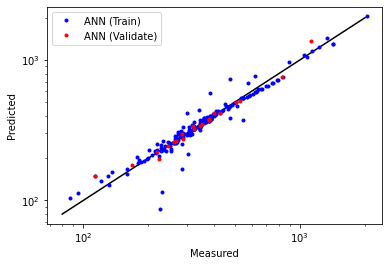

In [7]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(url)

# Size with hyperbolic tangent function
nin = 40  # inputs
n1 = 1   # hidden layer 1 (linear)
n2 = 5   # hidden layer 2 (nonlinear)
n3 = 1   # hidden layer 3 (linear)
nout = 1 # outputs

# input
d = np.array(data)[:,-40:]
d = np.array(d,dtype=float)

s_in_min = np.min(d,axis=0)
s_in_range = np.max(d,axis=0)-np.min(d,axis=0)
ds = np.empty_like(d)
for i in range(nin):
    for j in range(np.size(d,0)):
        ds[j,i] = (d[j,i]-s_in_min[i])/s_in_range[i]
ds_train = ds[0:205]
ds_valid = ds[205:]

# measured output
meas = np.array(data['Parachor'])
s_out_min = np.min(meas)
s_out_range = np.max(meas)-np.min(meas)
meass = np.empty_like(meas)
for j in range(len(meas)):
    meass[j] = (meas[j] - s_out_min) / s_out_range 
# scaled values
meas_train = meass[0:205]
meas_valid = meass[205:]
# unscaled values
umeas_train = meas[0:205]
umeas_valid = meas[205:]

# Initialize gekko
train = GEKKO(remote=False) 
test = GEKKO(remote=False)

model = [train,test]

for m in model:
    # input(s)
    m.inpt = [m.Param() for i in range(nin)]

    # layer 1
    m.w1 = m.Array(m.FV, (nin,n1))
    m.l1 = [sum([m.Intermediate(m.w1[j,i]*m.inpt[j]) for j in range(nin)]) for i in range(n1)]

    # layer 2
    m.w2 = m.Array(m.FV, (n1,n2))
    m.l2 = [m.Intermediate(sum([m.tanh(m.w2[j,i]*m.l1[j]) \
                           for j in range(n1)])) for i in range(n2)]

    # layer 3
    m.w3 = m.Array(m.FV, (n2,n3))
    m.l3 = [m.Intermediate(sum([m.w3[j,i]*m.l2[j] \
            for j in range(n2)])) for i in range(n3)]

    # output(s)
    m.outpt = m.CV()
    m.Equation(m.outpt==sum([m.l3[i] for i in range(n3)]))

    # flatten matrices
    m.w1 = m.w1.flatten()
    m.w2 = m.w2.flatten()
    m.w3 = m.w3.flatten()

# Fit parameter weights
m = train
for i in range(nin):
    m.inpt[i].value=ds_train[:,i]
m.outpt.value=meas_train
m.outpt.FSTATUS = 1
for i in range(len(m.w1)):
    m.w1[i].FSTATUS=1
    m.w1[i].STATUS=1
    m.w1[i].MEAS=1.0
    # add constraint
    m.w1[i].LOWER = 0.0
for i in range(len(m.w2)):
    m.w2[i].STATUS=1
    m.w2[i].FSTATUS=1
    m.w2[i].MEAS=0.5
for i in range(len(m.w3)):
    m.w3[i].FSTATUS=1
    m.w3[i].STATUS=1
    m.w3[i].MEAS=1.0
m.options.IMODE = 2
#m.options.OTOL = 1e-2
m.options.SOLVER = 1
m.options.EV_TYPE = 2
m.options.MAX_ITER = 1000
m.solve(disp=False)

# Test sample points
m = test
for i in range(len(m.w1)):
    m.w1[i].MEAS=train.w1[i].NEWVAL
    m.w1[i].FSTATUS = 1
for i in range(len(m.w2)):
    m.w2[i].MEAS=train.w2[i].NEWVAL
    m.w2[i].FSTATUS = 1
for i in range(len(m.w3)):
    m.w3[i].MEAS=train.w3[i].NEWVAL
    m.w3[i].FSTATUS = 1
for i in range(nin):
    m.inpt[i].value=ds_valid[:,i]
m.options.IMODE = 2
m.options.SOLVER = 1
m.solve(disp=False)

# unscale
pred_train = np.empty_like(meas_train)
for i in range(len(pred_train)):
    pred_train[i] = train.outpt.value[i] * s_out_range + s_out_min

pred_valid = np.empty_like(meas_valid)
for i in range(len(pred_valid)):
    pred_valid[i] = test.outpt.value[i] * s_out_range + s_out_min

print('ms_abs train')
print(np.sum(np.abs((umeas_train-pred_train)/umeas_train)/(len(umeas_train))))
print('ms_abs validate')
print(np.sum(np.abs((umeas_valid-pred_valid)/umeas_valid)/(len(umeas_valid))))

# parity plot
plt.loglog([80,2000],[80,2000],'k-')
plt.loglog(umeas_train,pred_train,'b.',label='ANN (Train)')
plt.loglog(umeas_valid,pred_valid,'r.',label='ANN (Validate)')
plt.legend()
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.savefig('ann_gekko.png')
plt.show()

Print neural network weights. Count the number of negative weights in `w1` (the first layer).

In [8]:
# Test sample points
m = test
for i in range(len(m.w1)):
    print('w1['+str(i)+']: '+str(m.w1[i].MEAS))
for i in range(len(m.w2)):
    print('w2['+str(i)+']: '+str(m.w2[i].MEAS))
for i in range(len(m.w3)):
    print('w3['+str(i)+']: '+str(m.w3[i].MEAS))

w1[0]: 10.319080175
w1[1]: 32.91335908
w1[2]: 6.0944692625
w1[3]: 2.308151337
w1[4]: 0.0
w1[5]: 0.0
w1[6]: 0.0
w1[7]: 14.299376757
w1[8]: 0.60986395312
w1[9]: 2.7674030425
w1[10]: 2.6796823846
w1[11]: 0.73116867139
w1[12]: 0.0
w1[13]: 1.1413015339
w1[14]: 0.0
w1[15]: 0.60654625179
w1[16]: 0.0
w1[17]: 0.379595279
w1[18]: 1.7335219949
w1[19]: 0.0
w1[20]: 0.0
w1[21]: 0.0
w1[22]: 1.583998029
w1[23]: 1.4661363818
w1[24]: 0.0
w1[25]: 0.0
w1[26]: 2.1562367568
w1[27]: 3.7066472231
w1[28]: 0.0
w1[29]: 0.0
w1[30]: 0.0
w1[31]: 0.32652566913
w1[32]: 3.2114206569
w1[33]: 0.0
w1[34]: 0.0
w1[35]: 0.0
w1[36]: 0.91819061636
w1[37]: 42.03326977
w1[38]: 6.5021149864
w1[39]: 7.2013072928
w2[0]: -0.067577657706
w2[1]: -0.067948596835
w2[2]: -0.051003874039
w2[3]: -0.046804777831
w2[4]: -0.060178962971
w3[0]: 65.282504389
w3[1]: 1.1694707932
w3[2]: 306.09568586
w3[3]: -179.08126103
w3[4]: -194.95847793


### Constrained Regression 

Add a constraint to the Gekko source with `m.w1[i].LOWER = 0.0` to enforce `w1` positive parameter weights. Alternatively, add a [positive weight constraint](https://keras.io/api/layers/constraints/) to the first layer in the Keras / TensorFlow source code. Report results on $R^2$, Mean Absolute Error, or similar performance metric for constrained and unconstrained results.

<img align=left width=550px src='https://apmonitor.com/pds/uploads/Main/parachor_constrained.png'>